In [1]:
%%time
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
print(role)
bucket='demoawsmeetup' # customize to your bucket

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

arn:aws:iam::461067907136:role/service-role/AmazonSageMaker-ExecutionRole-20190205T012270
CPU times: user 917 ms, sys: 97.6 ms, total: 1.01 s
Wall time: 7.16 s


In [3]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = "50" 
# we need to specify the input image shape for the training data
image_shape = "3,224,224"
# we also need to specify the number of training samples in the training set
# for caltech it is 15420
num_training_samples = "1755"
# specify the number of output classes
num_classes = "20"
# batch size for training
mini_batch_size =  "87"
# number of epochs
epochs = "30"
# learning rate
learning_rate = "0.01"

In [4]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name = 'DEMO-imageclassification-' + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/output'.format(bucket, job_name)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://demoawsmeetup/train",
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://demoawsmeetup/validation",
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))


Training job name: DEMO-imageclassification--2020-01-27-12-30-16

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://demoawsmeetup/train', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 55.7 ms, sys: 3.8 ms, total: 59.5 ms
Wall time: 110 ms


In [5]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [6]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


In [7]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name="DEMO-image-classification-model" + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

DEMO-image-classification-model-2020-01-27-12-57-10
s3://demoawsmeetup/output/DEMO-imageclassification--2020-01-27-12-30-16/output/model.tar.gz
arn:aws:sagemaker:us-east-2:461067907136:model/demo-image-classification-model-2020-01-27-12-57-10
CPU times: user 75.3 ms, sys: 4.46 ms, total: 79.8 ms
Wall time: 452 ms


In [8]:
from time import gmtime, strftime
print(job_name)
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = 'DEMO-imageclassification' + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

DEMO-imageclassification--2020-01-27-12-30-16
Endpoint configuration name: DEMO-imageclassification-epc--2020-01-27-12-57-14
Endpoint configuration arn:  arn:aws:sagemaker:us-east-2:461067907136:endpoint-config/demo-imageclassification-epc--2020-01-27-12-57-14


In [9]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = 'DEMO-imageclassification' + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: DEMO-imageclassification-ep--2020-01-27-12-57-25
EndpointArn = arn:aws:sagemaker:us-east-2:461067907136:endpoint/demo-imageclassification-ep--2020-01-27-12-57-25
CPU times: user 14.1 ms, sys: 0 ns, total: 14.1 ms
Wall time: 227 ms


In [10]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')


EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


In [11]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker')

--2020-01-27 13:05:50--  https://www.ornamental-trees.co.uk/images/spartan-apple-tree-p94-984_medium.jpg
Resolving www.ornamental-trees.co.uk (www.ornamental-trees.co.uk)... 104.26.5.96, 104.26.4.96, 2606:4700:20::681a:460, ...
Connecting to www.ornamental-trees.co.uk (www.ornamental-trees.co.uk)|104.26.5.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg           [ <=>                ] 102.37K  --.-KB/s    in 0.08s   

2020-01-27 13:05:51 (1.18 MB/s) - ‘/tmp/test.jpg’ saved [104831]



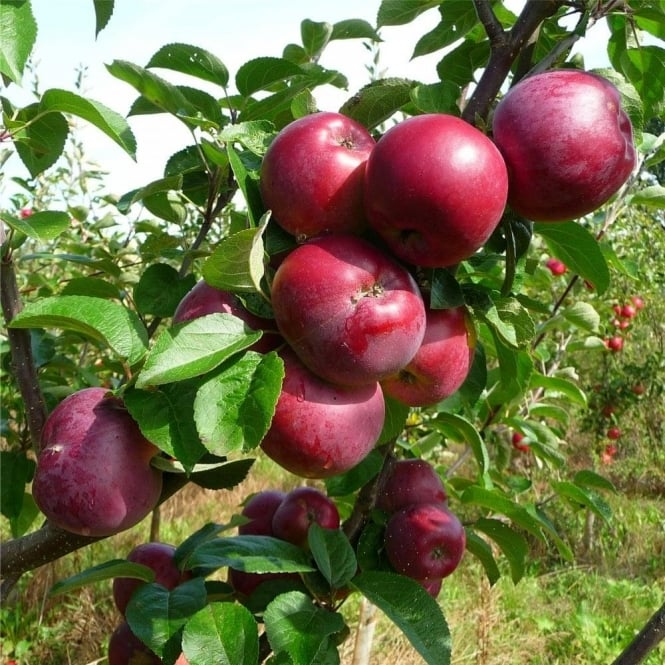

In [14]:
#apple
!wget -O /tmp/test.jpg https://www.ornamental-trees.co.uk/images/spartan-apple-tree-p94-984_medium.jpg
#palmyra 
#!wget -O /tmp/test.jpg http://climatesouthasia.org/wp-content/uploads/2016/08/Veilmuthu-1.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)

In [15]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['apple','arjuna','ashoka','avacado','banana','banyan','bitterguard','cinnamon','coconut','eucalyptus','guava','jackfruit','japaneese angelica','khair','mango','palmyra','papaya','pinus palustris','sandalwood','teak']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - apple, probability - 0.9962694644927979
